In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# Set the style for all plots
plt.style.use('ggplot')

# Estimated CPI data (based on publicly available information)
cpi_data = {
    'Year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'CPI': [218.056, 224.939, 229.594, 232.957, 236.736, 237.017, 240.007, 245.120, 251.107, 255.657, 258.811, 270.970, 292.655]
}

cpi_df = pd.DataFrame(cpi_data)
cpi_df['CPI_Increase'] = cpi_df['CPI'].pct_change()

# Historical and known future minimum wage data
wage_data = {
    'Year': [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Minimum Wage': [9.75, 10.25, 10.75, 11.25, 12.00, 12.75, 13.50, 14.20, 14.70]
}

wage_df = pd.DataFrame(wage_data)

# Merge wage data with CPI data
df = pd.merge(wage_df, cpi_df, on='Year', how='left')

# Function to predict minimum wage based on CPI increase
def predict_minimum_wage(current_wage, cpi_increase):
    new_wage = current_wage * (1 + cpi_increase)
    return round(new_wage * 20) / 20  # Round to nearest 5 cents

# Calculate average CPI increase for recent years
avg_cpi_increase = cpi_df['CPI_Increase'].tail(5).mean()

# Linear regression for trend analysis
X = df['Year'].values.reshape(-1, 1)
y = df['Minimum Wage'].values
model = LinearRegression().fit(X, y)

# Project future years
future_years = np.arange(2025, 2031)
projected_wages_trend = model.predict(future_years.reshape(-1, 1))

# Round trend projections to nearest 5 cents
projected_wages_trend_rounded = np.round(projected_wages_trend * 20) / 20

# Adjust projections based on CPI indexing
projected_wages_cpi = [14.70]  # Start with 2024 known wage
for _ in range(2025, 2031):
    projected_wages_cpi.append(predict_minimum_wage(projected_wages_cpi[-1], avg_cpi_increase))

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Projected Wage (Trend)': projected_wages_trend_rounded,
    'Projected Wage (CPI-indexed)': projected_wages_cpi[1:]
})

# Print forecast
print("Minimum Wage Forecast 2025-2030:")
print(forecast_df)

# Visualization 1: Historical data and projections
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Minimum Wage'], marker='o', label='Historical Data')
plt.plot(future_years, projected_wages_trend_rounded, marker='s', linestyle='--', label='Trend Projection')
plt.plot(future_years, projected_wages_cpi[1:], marker='^', linestyle='--', label='CPI-indexed Projection')
plt.title('Oregon Minimum Wage: Historical Data and Projections (2016-2030)')
plt.xlabel('Year')
plt.ylabel('Minimum Wage ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('minimum_wage_projections.png')
plt.close()

# Visualization 2: Minimum Wage vs CPI
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Minimum Wage ($)', color='tab:blue')
ax1.plot(df['Year'], df['Minimum Wage'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('CPI', color='tab:orange')
ax2.plot(cpi_df['Year'], cpi_df['CPI'], color='tab:orange', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Oregon Minimum Wage vs Consumer Price Index (2016-2022)')
fig.tight_layout()
plt.savefig('minimum_wage_vs_cpi.png')
plt.close()

# Visualization 3: Annual Increases
annual_increases = df['Minimum Wage'].pct_change().dropna() * 100
cpi_increases = cpi_df[cpi_df['Year'].isin(df['Year'])]['CPI_Increase'] * 100

# Find common years
common_years = sorted(set(df['Year'][1:]) & set(cpi_df['Year']))

# Filter data for common years
annual_increases = annual_increases[df['Year'].isin(common_years)]
cpi_increases = cpi_increases[cpi_df['Year'].isin(common_years)]

# Create a DataFrame with both increases
increases_df = pd.DataFrame({
    'Year': common_years,
    'Minimum Wage Increase': annual_increases.values,
    'CPI Increase': cpi_increases.values
})

print("Combined Increases Data:")
print(increases_df)

# Use only the years where we have both data points
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(increases_df))
plt.bar(index, increases_df['Minimum Wage Increase'], bar_width, label='Minimum Wage Increase')
plt.bar(index + bar_width, increases_df['CPI Increase'], bar_width, label='CPI Increase')
plt.xlabel('Year')
plt.ylabel('Percent Increase')
plt.title('Annual Increases: Minimum Wage vs CPI')
plt.xticks(index + bar_width/2, increases_df['Year'])
plt.legend()
plt.tight_layout()
plt.savefig('annual_increases.png')
plt.close()

# Print additional statistics
print("\nAdditional Statistics:")
print(f"Average annual CPI increase: {increases_df['CPI Increase'].mean():.2f}%")
print(f"Average annual Minimum Wage increase: {increases_df['Minimum Wage Increase'].mean():.2f}%")

# Visualization 4: Projection Comparison
melted_forecast = pd.melt(forecast_df, id_vars=['Year'], var_name='Projection Type', value_name='Projected Wage')
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Projected Wage', hue='Projection Type', data=melted_forecast)
plt.title('Comparison of Minimum Wage Projections (2025-2030)')
plt.ylabel('Projected Minimum Wage ($)')
plt.legend(title='Projection Method')
plt.tight_layout()
plt.savefig('projection_comparison.png')
plt.close()

# Calculate confidence interval for trend projection
degrees_of_freedom = len(X) - 2
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2, degrees_of_freedom)
prediction_std_error = np.sqrt(np.sum((y - model.predict(X))**2) / degrees_of_freedom)
margin_of_error = t_value * prediction_std_error * np.sqrt(1 + 1/len(X) + (future_years - np.mean(df['Year']))**2 / np.sum((df['Year'] - np.mean(df['Year']))**2))

lower_bound = np.round((projected_wages_trend - margin_of_error) * 20) / 20
upper_bound = np.round((projected_wages_trend + margin_of_error) * 20) / 20

# Visualization 5: Trend Projection with Confidence Interval
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Minimum Wage'], marker='o', label='Historical Data')
plt.plot(future_years, projected_wages_trend_rounded, marker='s', linestyle='--', label='Trend Projection')
plt.fill_between(future_years, lower_bound, upper_bound, alpha=0.2, label='95% Prediction Interval')
plt.title('Oregon Minimum Wage: Trend Projection with Confidence Interval (2016-2030)')
plt.xlabel('Year')
plt.ylabel('Minimum Wage ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('trend_projection_confidence_interval.png')
plt.close()

# Print additional statistics
print("\nAdditional Statistics:")
print(f"Average annual CPI increase (last 5 years): {avg_cpi_increase:.2%}")
print(f"Trend model R-squared: {model.score(X, y):.4f}")
print(f"Trend model coefficient: {model.coef_[0]:.4f}")
print("\n95% Prediction Interval for 2030 (Trend model):")
print(f"Lower bound: ${lower_bound[-1]:.2f}")
print(f"Upper bound: ${upper_bound[-1]:.2f}")

Minimum Wage Forecast 2025-2030:
   Year  Projected Wage (Trend)  Projected Wage (CPI-indexed)
0  2025                   15.35                         15.25
1  2026                   16.00                         15.80
2  2027                   16.65                         16.35
3  2028                   17.30                         16.95
4  2029                   17.95                         17.55
5  2030                   18.55                         18.20
Combined Increases Data:
   Year  Minimum Wage Increase  CPI Increase
0  2017               5.128205      2.130355
1  2018               4.878049      2.442477
2  2019               4.651163      1.811977
3  2020               6.666667      1.233684
4  2021               6.250000      4.698023
5  2022               5.882353      8.002731

Additional Statistics:
Average annual CPI increase: 3.39%
Average annual Minimum Wage increase: 5.58%

Additional Statistics:
Average annual CPI increase (last 5 years): 3.64%
Trend model R-sq

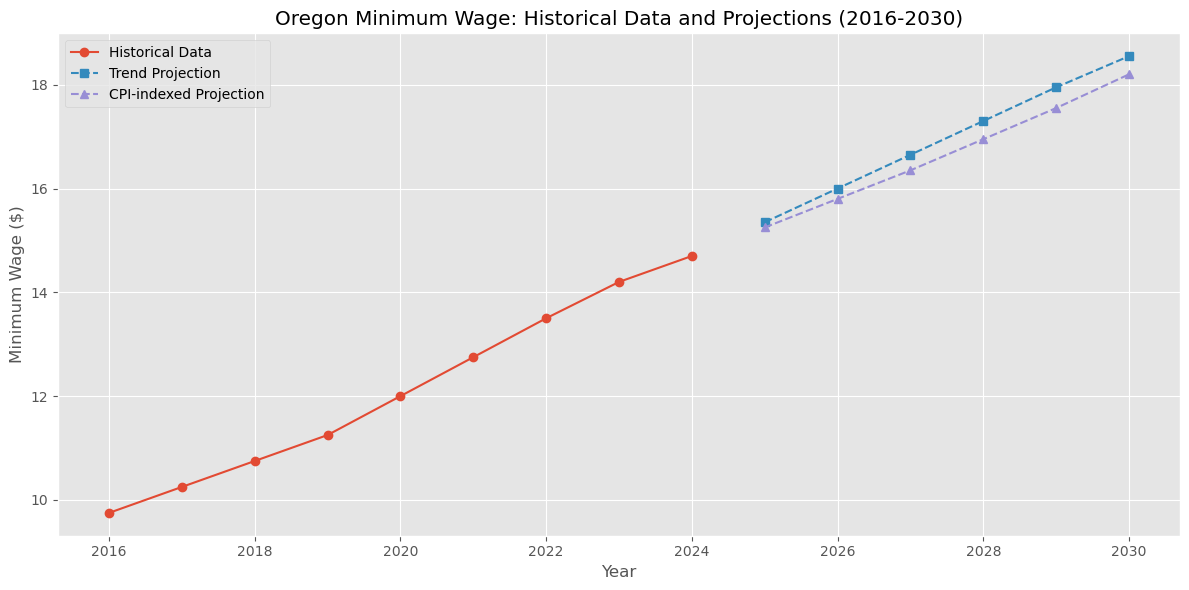

In [3]:
# Visualization 1: Historical data and projections
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Minimum Wage'], marker='o', label='Historical Data')
plt.plot(forecast_df['Year'], forecast_df['Projected Wage (Trend)'], marker='s', linestyle='--', label='Trend Projection')
plt.plot(forecast_df['Year'], forecast_df['Projected Wage (CPI-indexed)'], marker='^', linestyle='--', label='CPI-indexed Projection')
plt.title('Oregon Minimum Wage: Historical Data and Projections (2016-2030)')
plt.xlabel('Year')
plt.ylabel('Minimum Wage ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

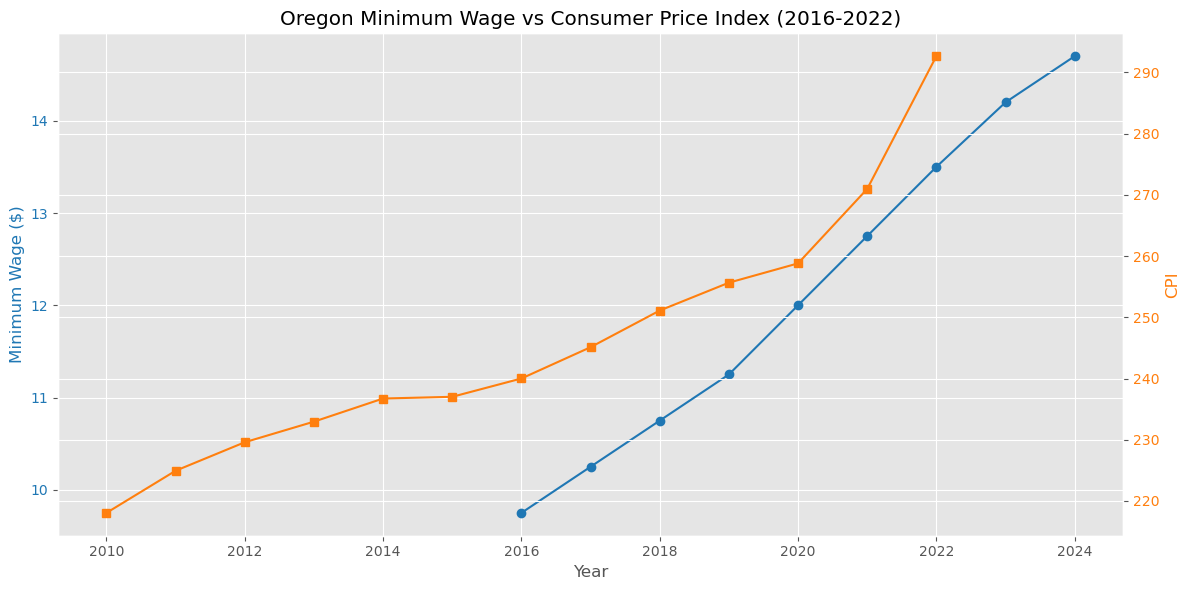

In [5]:
# Visualization 2: Minimum Wage vs CPI
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Year')
ax1.set_ylabel('Minimum Wage ($)', color='tab:blue')
ax1.plot(df['Year'], df['Minimum Wage'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('CPI', color='tab:orange')
ax2.plot(cpi_df['Year'], cpi_df['CPI'], color='tab:orange', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Oregon Minimum Wage vs Consumer Price Index (2016-2022)')
fig.tight_layout()
plt.show()

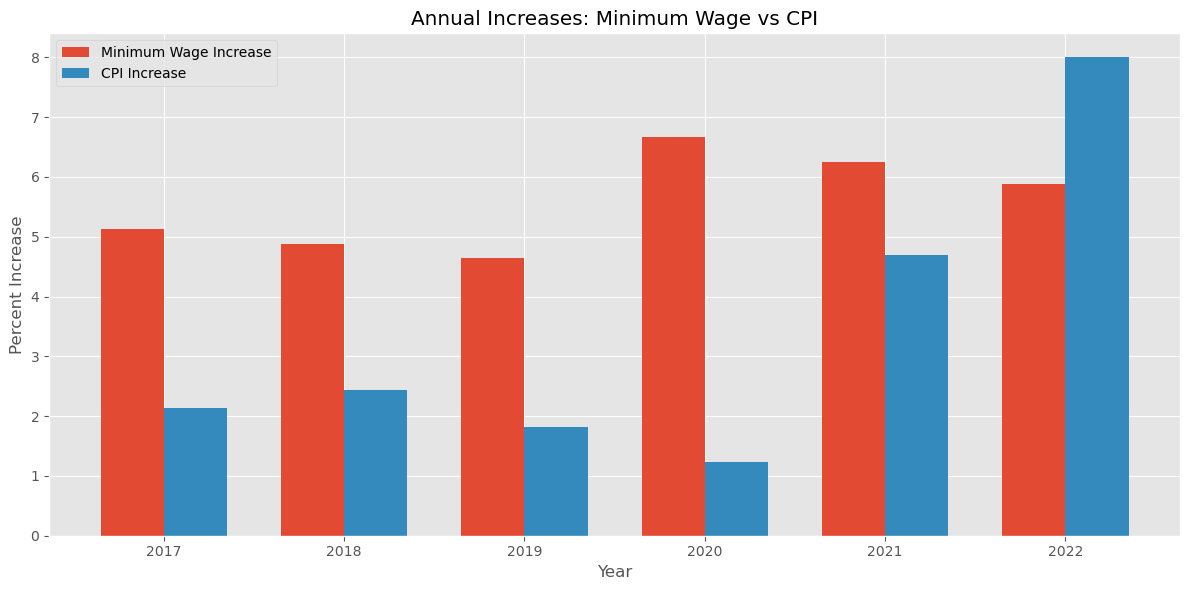

In [6]:
# Visualization 3: Annual Increases
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(increases_df))
plt.bar(index, increases_df['Minimum Wage Increase'], bar_width, label='Minimum Wage Increase')
plt.bar(index + bar_width, increases_df['CPI Increase'], bar_width, label='CPI Increase')
plt.xlabel('Year')
plt.ylabel('Percent Increase')
plt.title('Annual Increases: Minimum Wage vs CPI')
plt.xticks(index + bar_width/2, increases_df['Year'])
plt.legend()
plt.tight_layout()
plt.show()

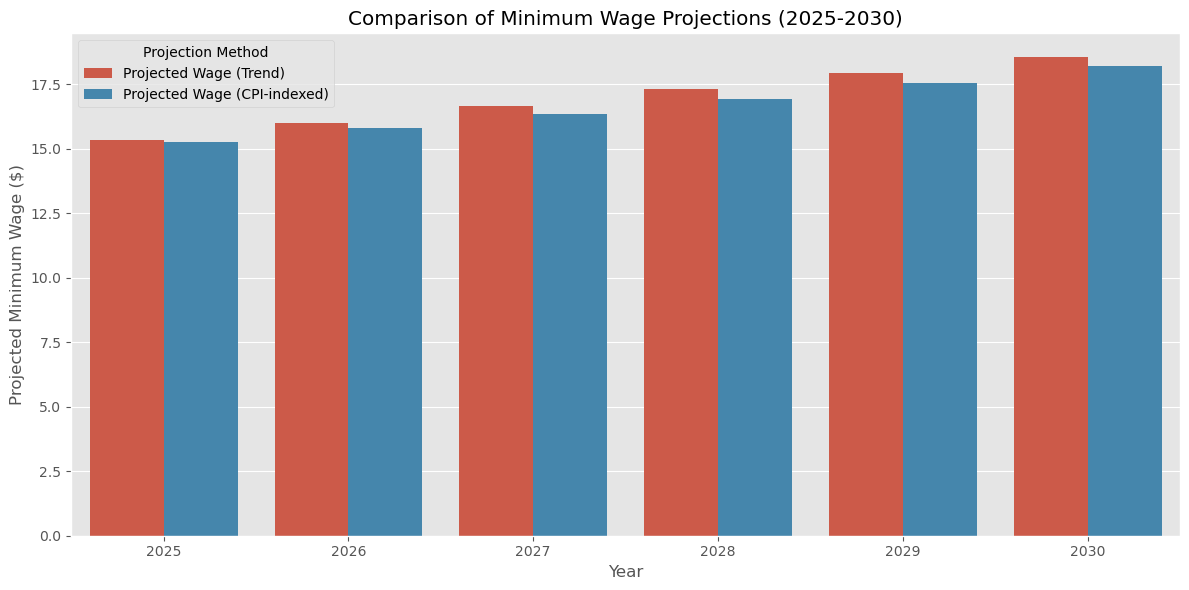

In [8]:
# Visualization 4: Projection Comparison
melted_forecast = pd.melt(forecast_df, id_vars=['Year'], var_name='Projection Type', value_name='Projected Wage')
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Projected Wage', hue='Projection Type', data=melted_forecast)
plt.title('Comparison of Minimum Wage Projections (2025-2030)')
plt.ylabel('Projected Minimum Wage ($)')
plt.legend(title='Projection Method')
plt.tight_layout()
plt.show()

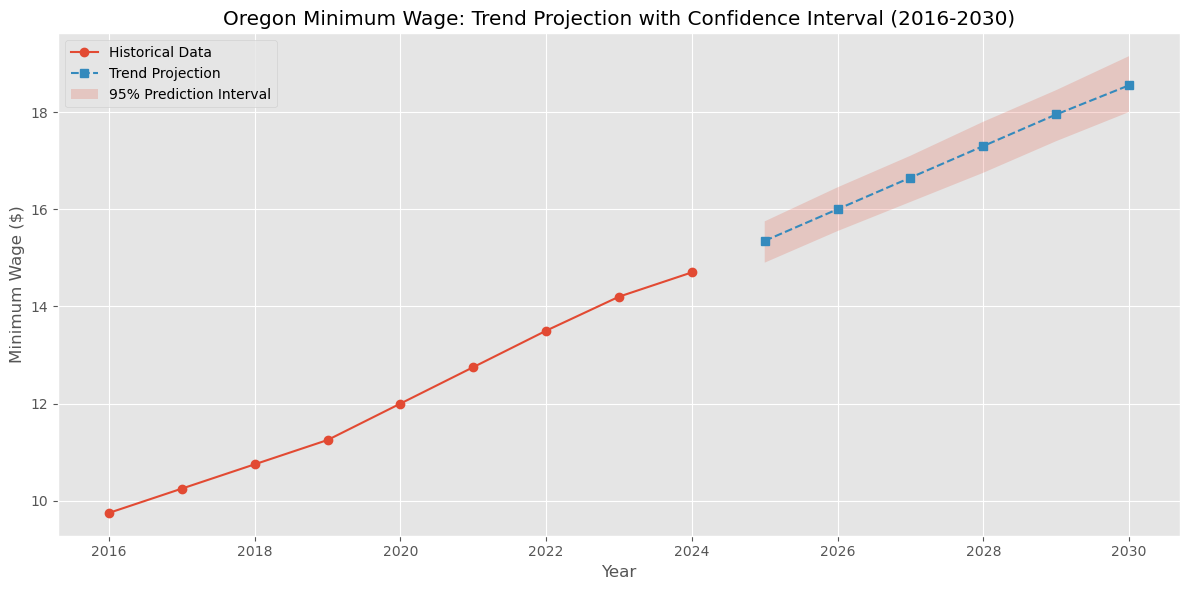

In [10]:
# Visualization 5: Trend Projection with Confidence Interval
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Minimum Wage'], marker='o', label='Historical Data')
plt.plot(forecast_df['Year'], forecast_df['Projected Wage (Trend)'], marker='s', linestyle='--', label='Trend Projection')
plt.fill_between(forecast_df['Year'], lower_bound, upper_bound, alpha=0.2, label='95% Prediction Interval')
plt.title('Oregon Minimum Wage: Trend Projection with Confidence Interval (2016-2030)')
plt.xlabel('Year')
plt.ylabel('Minimum Wage ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
cd

C:\Users\Alissa
